In [1]:
# load data
import glob
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer # https://realpython.com/k-means-clustering-python/

# modelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report

# load/save model
import pickle

# Load Data

- input: -
- output: `X, y`

In [2]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = glob.glob(path)
    images = np.array([import_image(file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [3]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

X = np.empty((0, 224, 224, 3), np.uint8)
y = np.empty((0))


for character in hanacaraka:
    file_path = "../Dataset/vzrenggamani/" + character + "/*.png"
    
    X_temp, y_temp = import_data(character, file_path)
    
    print("Ukuran karakter", character, ":", len(X_temp))
    
    X = np.append(X, X_temp, axis=0)
    y = np.append(y, y_temp, axis=0)

Ukuran karakter ba : 79
Ukuran karakter ca : 79
Ukuran karakter da : 79
Ukuran karakter dha : 77
Ukuran karakter ga : 78
Ukuran karakter ha : 78
Ukuran karakter ja : 78
Ukuran karakter ka : 79
Ukuran karakter la : 78
Ukuran karakter ma : 79
Ukuran karakter na : 79
Ukuran karakter nga : 79
Ukuran karakter nya : 78
Ukuran karakter pa : 77
Ukuran karakter ra : 75
Ukuran karakter sa : 79
Ukuran karakter ta : 76
Ukuran karakter tha : 77
Ukuran karakter wa : 79
Ukuran karakter ya : 79


In [4]:
# Ukuran keseluruhan data
print("Ukuran data:", X.shape[0])

Ukuran data: 1562


<AxesSubplot:ylabel='count'>

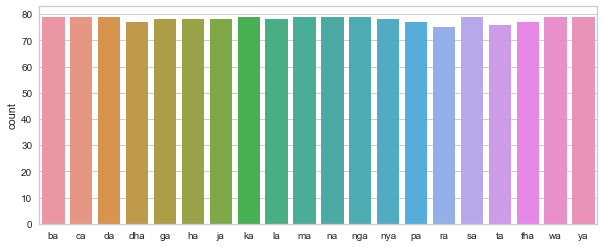

In [5]:
plt.figure(figsize=(10,4))
sns.countplot(x=y)

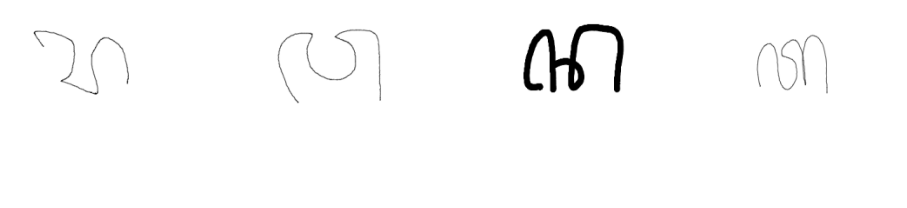

In [6]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X[np.random.randint(0, X.shape[0]), 0:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Preprocessing

- input: `X`
- output: `X_prep`

kind of image preprocessing
- grayscaling (o)
- resizing (x)
- cropping (x)
- binarization (o)
- negative (x)
- skeletonization/thinning (o)
- noise reduction (x)
- sharpening (o)

In [7]:
def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image
    
def thresholding(image, th):
    ret, image = cv2.threshold(image, th, 255, cv2.THRESH_BINARY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

# https://soumyapatilblogs.medium.com/image-filtering-using-opencv-66b67e1bd968
def denoising(image):
    image = cv2.medianBlur(image, 5)
    return image

def sharpening(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    #kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    return image

def edge_detecting(image):
    if (image.ndim == 3):
        image = grayscaling(image)
    #image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.Canny(image=image, threshold1=100, threshold2=200)
    return image

def equalizing(image):
    image = cv2.equalizeHist(image)
    return image

def boundary_detecting(image_canny):
    x_start, x_end, y_start, y_end = 0, 223, 0, 223
    for i in range(image_canny.shape[0]):
        if(image_canny[i].max() > 240):
            x_start = i - 10
            if(x_start < 0):
                x_start = 0
            break

    for i in range(image_canny.shape[0]-1, 0, -1):
        if(image_canny[i].max() > 240):
            x_end = i + 10
            if(x_end > 255):
                x_end = 255
            break

    for i in range(image_canny.shape[1]):
        if(image_canny[:, i].max() > 240):
            y_start = i - 10
            if(y_start < 0):
                y_start = 0
            break

    for i in range(image_canny.shape[1]-1, 0, -1):
        if(image_canny[:, i].max() > 240):
            y_end = i + 10
            if(y_end > 255):
                y_end = 255
            break

    return x_start, x_end, y_start, y_end

def boundary_cropping(image):
    image_canny = edge_detecting(image)
    x_start, x_end, y_start, y_end = boundary_detecting(image_canny)
    image = image[x_start:x_end, y_start:y_end]
    return image

In [42]:
def preprocessing(image, size=192, th=127):
    image = grayscaling(image)
    image = boundary_cropping(image)
    image = resizing(image, size)
    image = equalizing(image)
    return image

In [43]:
X_prep = []

for i in range(X.shape[0]) :
    X_prep.append(preprocessing(X[i], 28))
    
X_prep = np.array(X_prep, dtype=np.uint8)

In [44]:
print("Dimensi data:", X_prep.shape)

Dimensi data: (1562, 28, 28)


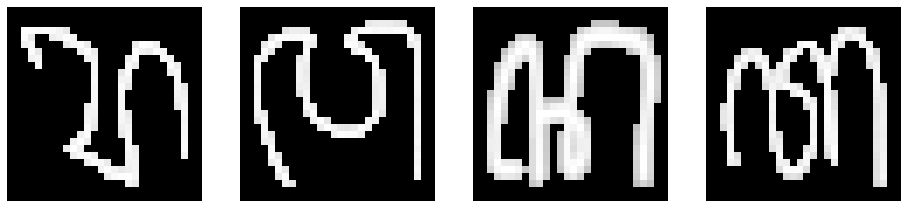

In [45]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X_prep[np.random.randint(0, X.shape[0]), 0:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Classification

- input: `X_prep, y`
- output: -

In [12]:
# reshape data
X_feature = np.reshape(X_prep, (X.shape[0], 28*28))
X_feature.shape

(1562, 784)

In [13]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

In [14]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.2, random_state=42)

print("Ukuran data training:", X_train.shape[0])
print("Ukuran data testing:", X_test.shape[0])

Ukuran data training: 1249
Ukuran data testing: 313


## KNN

In [15]:
knn_params = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
knn_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params, cv=5, verbose=3)

In [16]:
knn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.416 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.476 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.416 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.460 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.462 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.424 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;, score=0.468 total time=   0.0s
[CV 3/5] END .....................n_neighbors=3;, score=0.480 total time=   0.0s
[CV 4/5] END .....................n_neighbors=3;, score=0.476 total time=   0.0s
[CV 5/5] END .....................n_neighbors=3;, score=0.466 total time=   0.0s
[CV 1/5] END .....................n_neighbors=5;, score=0.432 total time=   0.0s
[CV 2/5] END .....................n_neighbors=5;

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             verbose=3)

In [17]:
print("Model terbaik:", knn_cv.best_estimator_)
print("Score terbaik:", knn_cv.best_score_)

Model terbaik: KNeighborsClassifier(n_neighbors=15)
Score terbaik: 0.5044305220883534


In [18]:
cv_results_df = pd.DataFrame(knn_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
15,{'n_neighbors': 15},1,0.504431,0.024452
13,{'n_neighbors': 13},2,0.502831,0.019797
17,{'n_neighbors': 17},3,0.500402,0.011056
9,{'n_neighbors': 9},4,0.498002,0.013624
11,{'n_neighbors': 11},5,0.496431,0.027539
19,{'n_neighbors': 19},6,0.493208,0.013492
7,{'n_neighbors': 7},7,0.492402,0.017546
5,{'n_neighbors': 5},8,0.473186,0.024575
3,{'n_neighbors': 3},9,0.462773,0.020060


In [19]:
y_pred = knn_cv.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.71      0.53      0.61        19
          ca       0.33      0.22      0.27         9
          da       0.50      0.50      0.50        16
         dha       0.42      0.44      0.43        18
          ga       0.75      0.60      0.67        20
          ha       0.31      0.53      0.39        15
          ja       1.00      0.74      0.85        19
          ka       0.75      0.57      0.65        21
          la       0.67      0.50      0.57        16
          ma       0.89      0.50      0.64        16
          na       0.65      0.73      0.69        15
         nga       0.38      0.46      0.41        13
         nya       0.69      0.60      0.64        15
          pa       0.26      0.80      0.39        15
          ra       0.71      0.62      0.67        16
          sa       0.43      0.46      0.44        13
          ta       0.75      0.20      0.32        15
         tha       1.00    

### SVM

In [21]:
svm_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto', 0.0005, 0.0008, 0.0015, 0.0018]
}
svm_cv = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=svm_params, cv=5, verbose=3)

In [22]:
svm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...................C=1, gamma=auto;, score=0.636 total time=   0.4s
[CV 2/5] END ...................C=1, gamma=auto;, score=0.656 total time=   0.3s
[CV 3/5] END ...................C=1, gamma=auto;, score=0.608 total time=   0.3s
[CV 4/5] END ...................C=1, gamma=auto;, score=0.684 total time=   0.3s
[CV 5/5] END ...................C=1, gamma=auto;, score=0.679 total time=   0.3s
[CV 1/5] END .................C=1, gamma=0.0005;, score=0.608 total time=   0.3s
[CV 2/5] END .................C=1, gamma=0.0005;, score=0.648 total time=   0.3s
[CV 3/5] END .................C=1, gamma=0.0005;, score=0.612 total time=   0.3s
[CV 4/5] END .................C=1, gamma=0.0005;, score=0.660 total time=   0.3s
[CV 5/5] END .................C=1, gamma=0.0005;, score=0.647 total time=   0.3s
[CV 1/5] END .................C=1, gamma=0.0008;, score=0.624 total time=   0.3s
[CV 2/5] END .................C=1, gamma=0.0008

[CV 2/5] END ..................C=15, gamma=auto;, score=0.700 total time=   0.3s
[CV 3/5] END ..................C=15, gamma=auto;, score=0.644 total time=   0.3s
[CV 4/5] END ..................C=15, gamma=auto;, score=0.688 total time=   0.3s
[CV 5/5] END ..................C=15, gamma=auto;, score=0.695 total time=   0.3s
[CV 1/5] END ................C=15, gamma=0.0005;, score=0.676 total time=   0.3s
[CV 2/5] END ................C=15, gamma=0.0005;, score=0.708 total time=   0.3s
[CV 3/5] END ................C=15, gamma=0.0005;, score=0.672 total time=   0.3s
[CV 4/5] END ................C=15, gamma=0.0005;, score=0.696 total time=   0.3s
[CV 5/5] END ................C=15, gamma=0.0005;, score=0.683 total time=   0.3s
[CV 1/5] END ................C=15, gamma=0.0008;, score=0.668 total time=   0.3s
[CV 2/5] END ................C=15, gamma=0.0008;, score=0.692 total time=   0.3s
[CV 3/5] END ................C=15, gamma=0.0008;, score=0.660 total time=   0.3s
[CV 4/5] END ...............

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 3, 6, 10, 15],
                         'gamma': ['auto', 0.0005, 0.0008, 0.0015, 0.0018]},
             verbose=3)

In [23]:
print("Model terbaik:", svm_cv.best_estimator_)
print("Score terbaik:", svm_cv.best_score_)

Model terbaik: SVC(C=10, gamma=0.0005)
Score terbaik: 0.6869461847389557


In [24]:
cv_results_df = pd.DataFrame(svm_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10_0.0005,"{'C': 10, 'gamma': 0.0005}",1,0.686946,0.013313
15_0.0005,"{'C': 15, 'gamma': 0.0005}",1,0.686946,0.013313
3_0.0005,"{'C': 3, 'gamma': 0.0005}",3,0.686133,0.019625
6_0.0008,"{'C': 6, 'gamma': 0.0008}",4,0.684556,0.015714
6_0.0005,"{'C': 6, 'gamma': 0.0005}",5,0.684540,0.014786
15_0.0008,"{'C': 15, 'gamma': 0.0008}",6,0.683756,0.016804
10_0.0008,"{'C': 10, 'gamma': 0.0008}",6,0.683756,0.016804
3_0.0008,"{'C': 3, 'gamma': 0.0008}",8,0.681346,0.018322
3_0.0015,"{'C': 3, 'gamma': 0.0015}",9,0.674962,0.021659


In [25]:
y_pred = svm_cv.predict(X_test)

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.87      0.68      0.76        19
          ca       0.50      0.44      0.47         9
          da       0.82      0.88      0.85        16
         dha       0.71      0.67      0.69        18
          ga       0.54      0.70      0.61        20
          ha       0.53      0.67      0.59        15
          ja       0.94      0.89      0.92        19
          ka       0.74      0.81      0.77        21
          la       0.59      0.62      0.61        16
          ma       0.93      0.81      0.87        16
          na       0.85      0.73      0.79        15
         nga       0.59      0.77      0.67        13
         nya       0.81      0.87      0.84        15
          pa       0.75      0.80      0.77        15
          ra       0.80      0.75      0.77        16
          sa       0.65      0.85      0.73        13
          ta       0.71      0.33      0.45        15
         tha       0.91    